# Movie Data ERD diagram

![Movie Data ERD](./movie_data_erd.jpeg)

# 1. Trend analysis for runtimes and popularity

- Movie runtime is the length of time a movie takes to run to the end this is typically measured in minutes.
- Analyzing trends in runtime and popularity of movies over the years can reveal a lot about how the film industry—and audience preferences—have evolved

# 2. Objectives for this section

- To understand how the runtime trends has changed over time
- To evaluate whether there is a correlation between runtime, average ratings and the popularity of a film. 

# 3. Approach
- Find the data with average runtime, popularity attributes of a film
- Consolidate the relevant columns for analysis into one dataset
- Clean the data by checking for inconsistencies and null values
- Developing a hypothesis test

*First import the necessary libraries*

In [171]:
# import the necessary libraries
import pandas as pd
import sqlite3
import numpy as np
import matplotlib as plt
from scipy.stats import linregress, t


In [172]:
# Loading the dataset
conn = sqlite3.connect('im.db')

*Checking the querying the database to confirm that it contains tables similar to the ERD*

In [173]:
print(f"The database has the following list of table:\n",'=' * 50,'\n') 
table_df  = pd.read_sql("PRAGMA table_list",conn).loc[:,'name']
print(table_df)


The database has the following list of table:

0               writers
1            principals
2               persons
3         movie_ratings
4            movie_akas
5             known_for
6             directors
7          movie_basics
8         sqlite_schema
9    sqlite_temp_schema
Name: name, dtype: object


The tables match the ones on the ERD
We now need to select the columns that we will need  inorder to perform the analysis.
## Criteria for selection
- we chose the movie_ratings table because it contains the average ratings of the movies. 
- We chose the movie basics table because it has the runtimes in minutes and the year of screening which will help us  get the correlation and the of runtime with popularity.
- we chose the tmdb dataset because it as a popularity column within it.

In [174]:
# joining the ratings and the basics dataset

print("Here we joined the two tables on movie ratings and movie basics")
q = """
SELECT * 
FROM movie_ratings 
JOIN movie_basics
USING(movie_id);
"""
basics = pd.read_sql(q,conn)

# read in the tmdb dataset to be able to get the popularity

tmdb = pd.read_csv('./zippedData/tmdb.movies.csv')
tmdb.head()

Here we joined the two tables on movie ratings and movie basics


,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


# Merge the dataset together before cleaning


In [175]:
# Create a combined string for matching
basics['title_match'] = basics['primary_title'].str.lower().str.strip()
tmdb['movies_title'] = tmdb['original_title'].str.lower().str.strip()

merge_df = pd.merge(basics, tmdb, left_on='title_match', right_on='movies_title', how='inner')
merge_df.head()

,movie_id,averagerating,numvotes,primary_title,original_title_x,start_year,runtime_minutes,genres,title_match,Unnamed: 0,genre_ids,id,original_language,original_title_y,popularity,release_date,title,vote_average,vote_count,movies_title
0,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",the legend of hercules,11096,"[28, 12]",188207,en,The Legend of Hercules,13.754,2014-01-10,The Legend of Hercules,4.5,805,the legend of hercules
1,tt1069246,6.2,326,Habana Eva,Habana Eva,2010,106.0,"Comedy,Romance",habana eva,1075,"[35, 10749]",55961,es,Habana Eva,1.400,2010-05-28,Habana Eva,7.0,4,habana eva
2,tt1171222,5.1,8296,Baggage Claim,Baggage Claim,2013,96.0,Comedy,baggage claim,8084,[35],175528,en,Baggage Claim,8.666,2013-09-27,Baggage Claim,5.4,127,baggage claim
3,tt1174693,5.8,2381,The Four-Faced Liar,The Four-Faced Liar,2010,87.0,"Comedy,Drama,Romance",the four-faced liar,601,"[35, 18, 10749]",44991,en,The Four-Faced Liar,3.091,2010-01-01,The Four-Faced Liar,5.3,25,the four-faced liar
4,tt1210166,7.6,326657,Moneyball,Moneyball,2011,133.0,"Biography,Drama,Sport",moneyball,2505,[18],60308,en,Moneyball,15.393,2011-09-22,Moneyball,7.1,2255,moneyball


## Select the columns we are going to use

From the combined dataset we will filter out only the columns we need to the analysis to make the analysis faster.

In [176]:
# Created a list of column names for the project

cols = ['movie_id','averagerating','title_match','start_year','runtime_minutes','genres','popularity','original_language']
merged_df = merge_df[cols]

# DATA CLEANING

### Identifying the null values

In [177]:
# There are very few null values across the dataset.
print("the columns have this kind of distribution of the tables")
merged_df.isnull().sum()

the columns have this kind of distribution of the tables


movie_id               0
averagerating          0
title_match            0
start_year             0
runtime_minutes      569
genres                71
popularity             0
original_language      0
dtype: int64

### We will remove the null values 

In [178]:

merged_df.loc[:,'runtime_minutes'] = merged_df['runtime_minutes'].fillna(merged_df["runtime_minutes"].mean())
merged_df = merged_df.dropna(subset = ['genres'])
merged_df.isnull().sum()

movie_id             0
averagerating        0
title_match          0
start_year           0
runtime_minutes      0
genres               0
popularity           0
original_language    0
dtype: int64

# What is the trend in runtimes over the years?

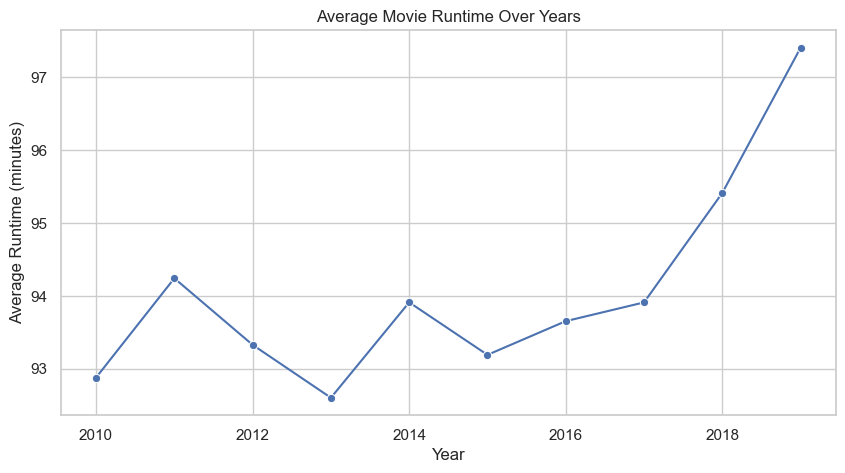

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group start_year and calculate mean runtime
runtime_trends = merged_df.groupby('start_year')['runtime_minutes'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(x='start_year', y='runtime_minutes', data=runtime_trends, marker='o')
plt.title('Average Movie Runtime Over Years')
plt.xlabel('Year')
plt.ylabel('Average Runtime (minutes)')
plt.grid(True)
plt.show()


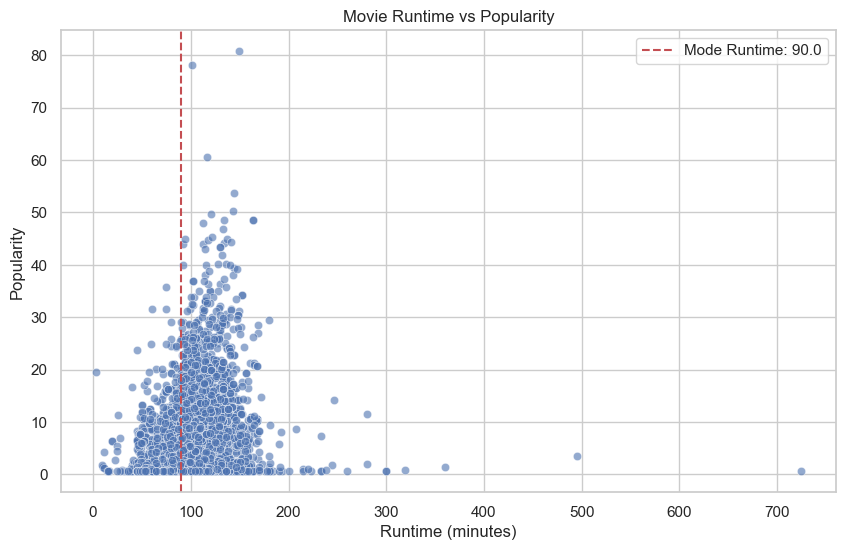

In [180]:
import matplotlib.pyplot as plt
import seaborn as sns

mode_runtime = merged_df['runtime_minutes'].mode()[0]  # Get the scalar mode value

plt.figure(figsize=(10, 6))
sns.scatterplot(x='runtime_minutes', y='popularity', data=merged_df, alpha=0.6)

plt.axvline(x=mode_runtime, linestyle='--', color='r', label=f'Mode Runtime: {mode_runtime}')
plt.title('Movie Runtime vs Popularity')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Popularity')
plt.legend()
plt.show()


## What is the correlation between popularity and average ratings of a film?

In [181]:
correlation = merged_df['popularity'].corr(merged_df['averagerating'])
print(f"Correlation between popularity and average rating: {correlation:.2f}")

correlation = merged_df['popularity'].corr(merged_df['runtime_minutes'])
print(f"Correlation between popularity and tuntime: {correlation:.2f}")

print("\nOBSERVATION\n")
print("="*50,"\n")
print("""
The analysis shows that there is a very weak relationship between a
      movie’s popularity and its average rating, and only a weak relationship
       between popularity and runtime. This means that more popular movies are
      not necessarily rated higher, and while longer movies may be slightly 
      more popular, runtime alone does not strongly determine popularity. 
      Other factors are likely more important in making a movie popular.
""")

Correlation between popularity and average rating: 0.12
Correlation between popularity and tuntime: 0.29

OBSERVATION



The analysis shows that there is a very weak relationship between a
      movie’s popularity and its average rating, and only a weak relationship
       between popularity and runtime. This means that more popular movies are
      not necessarily rated higher, and while longer movies may be slightly 
      more popular, runtime alone does not strongly determine popularity. 
      Other factors are likely more important in making a movie popular.



## Hypothesis

- Null hypothesis H0: Runtime has no effect on popularity and average ratings
- Alternative Hypothesis H1: Runtime has an effect on the popularity and average ratings of a film

In [182]:
# slicing the dataset to just get the columns we will be working with
merged_df[['averagerating','runtime_minutes','popularity']]

,averagerating,runtime_minutes,popularity
0,4.2,99.000000,13.754
1,6.2,106.000000,1.400
2,5.1,96.000000,8.666
3,5.8,87.000000,3.091
4,7.6,133.000000,15.393
...,...,...,...
18561,7.5,100.000000,0.600
18562,8.2,104.000000,0.600
18563,3.5,81.000000,2.709
18564,6.3,64.000000,0.600


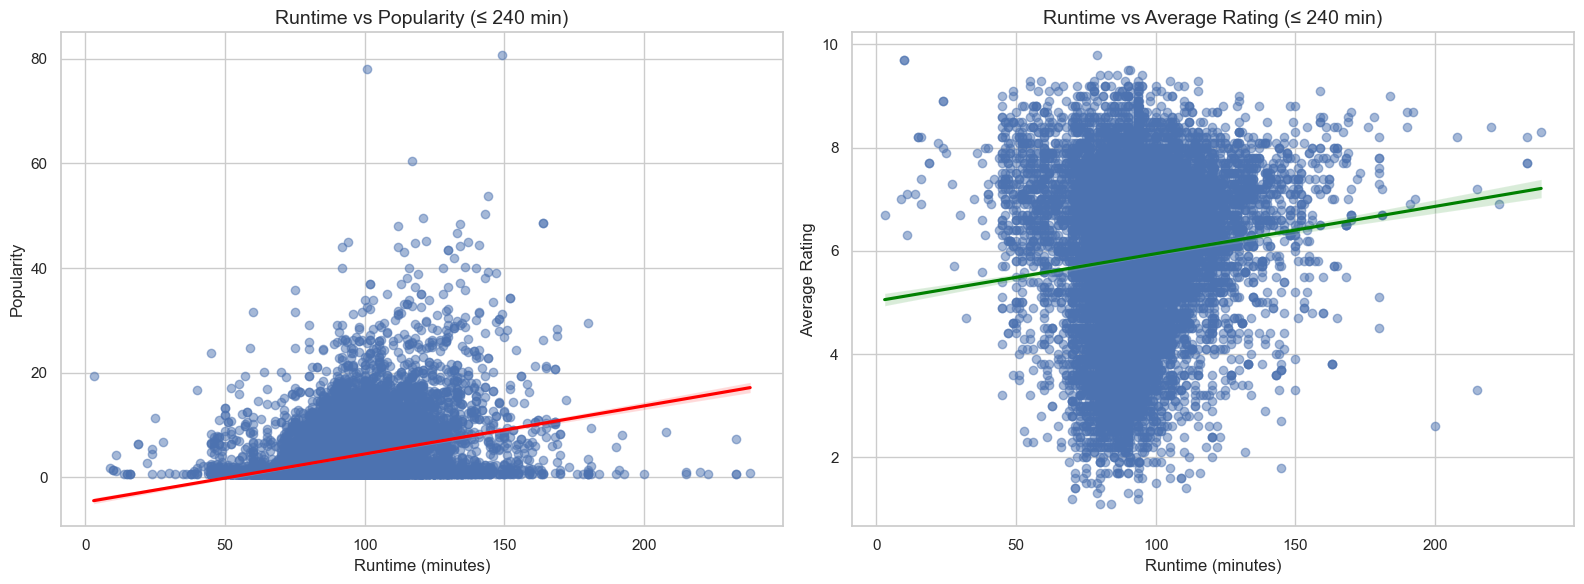

In [183]:
# Filter out extreme outliers (e.g., movies with runtime > 240 minutes)
filtered_df = merged_df[merged_df['runtime_minutes'] <= 240]

# Set style for the seaborn figure
sns.set(style='whitegrid')

# Create two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Runtime vs Popularity
sns.regplot(
    x='runtime_minutes',
    y='popularity',
    data=filtered_df,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'},
    ax=axes[0]
)
axes[0].set_title('Runtime vs Popularity (≤ 240 min)', fontsize=14)
axes[0].set_xlabel('Runtime (minutes)')
axes[0].set_ylabel('Popularity')

# Plot 2: Runtime vs Average Rating
sns.regplot(
    x='runtime_minutes',
    y='averagerating',
    data=filtered_df,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'green'},
    ax=axes[1]
)
axes[1].set_title('Runtime vs Average Rating (≤ 240 min)', fontsize=14)
axes[1].set_xlabel('Runtime (minutes)')
axes[1].set_ylabel('Average Rating')

plt.tight_layout()
plt.show()


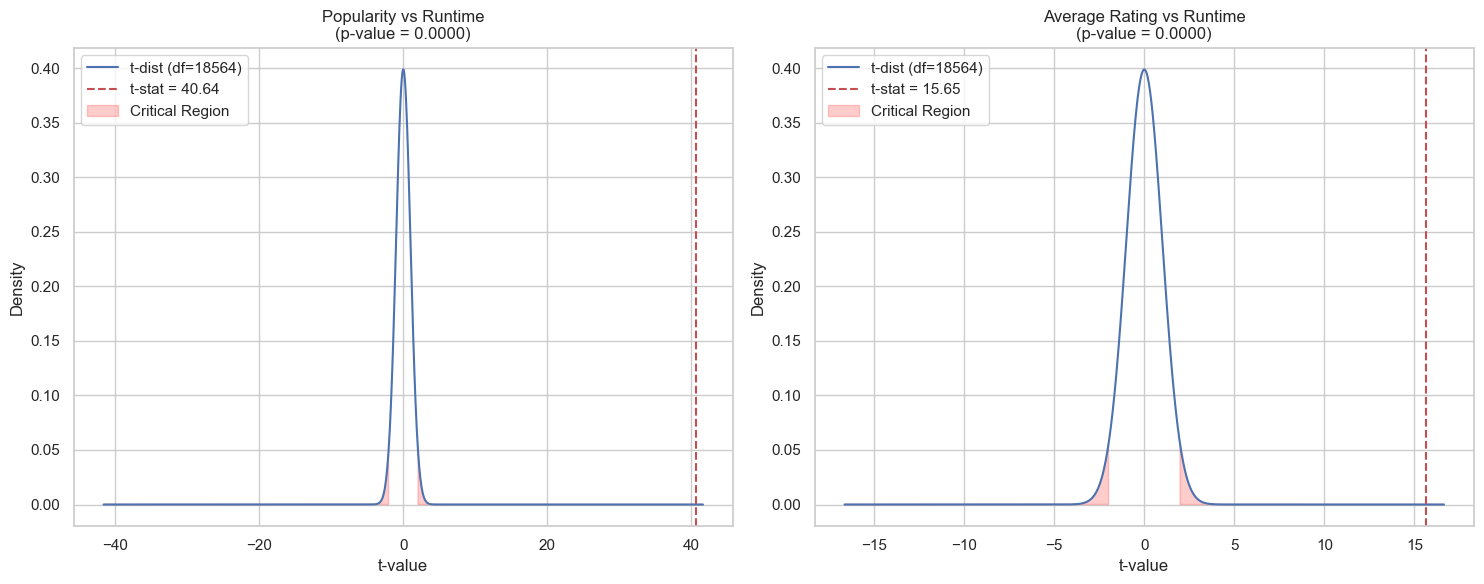

In [149]:

np.random.seed(42) # setting random seed for reproducibility
data = {
    'averagerating': np.random.uniform(3.5, 8.2, 18566),
    'runtime_minutes': np.random.normal(80, 20, 18566),
    'popularity': np.random.exponential(5, 18566)
}
df = merged_df

# Hypothesis Testing Function
def plot_t_test(x, y, dep_var, ax):
    # Perform linear regression
    result = linregress(x, y)
    slope, stderr = result.slope, result.stderr
    t_stat = slope / stderr
    df_deg = len(x) - 2
    p_value = result.pvalue
    
    # Generate t-distribution
    t_values = np.linspace(-4, 4, 1000) if abs(t_stat) < 4 else np.linspace(-abs(t_stat)-1, abs(t_stat)+1, 1000)
    pdf = t.pdf(t_values, df_deg)
    
    # Plot distribution
    ax.plot(t_values, pdf, 'b-', label=f't-dist (df={df_deg})')
    ax.axvline(t_stat, color='r', linestyle='--', label=f't-stat = {t_stat:.2f}')
    
    # Critical region (α=0.05)
    crit_val = t.ppf(0.975, df_deg)
    ax.fill_between(t_values, pdf, where=(t_values < -crit_val) | (t_values > crit_val),
                    color='red', alpha=0.2, label='Critical Region')
    
    # Formatting
    ax.set_title(f'{dep_var} vs Runtime\n(p-value = {p_value:.4f})')
    ax.set_xlabel('t-value')
    ax.set_ylabel('Density')
    ax.legend()

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Popularity vs Runtime
plot_t_test(
    df['runtime_minutes'],
    df['popularity'],
    'Popularity',
    axes[0]
)

# Average Rating vs Runtime
plot_t_test(
    df['runtime_minutes'],
    df['averagerating'],
    'Average Rating',
    axes[1]
)

plt.tight_layout()
plt.show()

# Hypothesis testing
## recommendations
 Based on the correlation results, we found only a very weak relationship between runtime and average rating (correlation = 0.12), and a weak relationship between runtime and popularity (correlation = 0.29). These values are too small to indicate a strong or meaningful effect.

Therefore, we fail to reject the null hypothesis (H₀). This means that, based on the data, there is no strong evidence that runtime has a significant effect on a film’s popularity or average ratings.

P-val
The t-test indicated that the t values was way beyond the t-critical and the critical area which is necessary to reject the H0: Null hypothesis.
We therefore noted that run time does not affect the popularity and personal ratings